## Setup

In [2]:
import time
import random
from math import isclose
from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import spacy
from spacy.util import minibatch, compounding
from sklearn.metrics import confusion_matrix, classification_report

## EDA and Data Preparation

In [3]:
reviews = pd.read_csv("Yelp_restaurant_reviews.csv")
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
review_id        100000 non-null object
stars            100000 non-null int64
text             100000 non-null object
review_length    100000 non-null int64
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [4]:
reviews.head()

,review_id,stars,text,review_length
0,kMWkKrJkqHx5SW9sz_JEnw,5,The best service I had was here during my time...,300
1,GFcNYpLZYlcpBQNrVjMh8Q,4,"What a fun place. Valet parking, a great outsi...",190
2,6ov3a4K8metST0LxtoJ4sA,3,My boyfriend and I dropped in for the first ti...,252
3,ahiXWr5mSXt9x0fbS4l-Cw,4,Excellent of breakfast or Sunday brunch! There...,326
4,9Ld-tBcjbtoMG-qx_l5G4A,4,I would actually give this place a 4.5 stars i...,2570


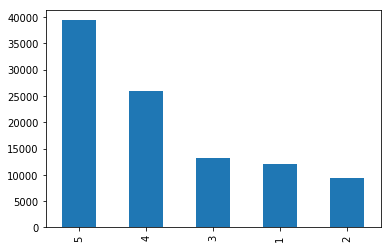

In [64]:
ax = reviews['stars'].value_counts().plot(kind='bar')  # note the bars are ordered by frequency not star number

In [8]:
# to deal with the unbalanced data (and to make the classifier binary instead of multiclass), put ratings 4-5 as positive and ratings 1-3 as negative
reviews['is_positive'] = reviews['stars'] > 3
reviews.head()

,review_id,stars,text,review_length,is_positive
0,kMWkKrJkqHx5SW9sz_JEnw,5,The best service I had was here during my time...,300,True
1,GFcNYpLZYlcpBQNrVjMh8Q,4,"What a fun place. Valet parking, a great outsi...",190,True
2,6ov3a4K8metST0LxtoJ4sA,3,My boyfriend and I dropped in for the first ti...,252,False
3,ahiXWr5mSXt9x0fbS4l-Cw,4,Excellent of breakfast or Sunday brunch! There...,326,True
4,9Ld-tBcjbtoMG-qx_l5G4A,4,I would actually give this place a 4.5 stars i...,2570,True


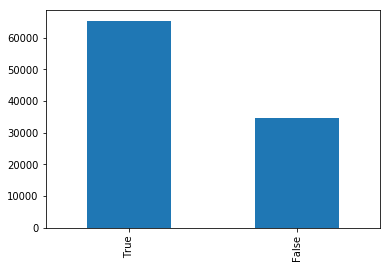

In [9]:
ax = reviews['is_positive'].value_counts().plot(kind='bar')

In [10]:
reviews['star_tuples'] = reviews.apply(lambda row: (row['text'], str(row['stars']) ), axis=1 )

In [11]:
reviews['tuples'] = reviews.apply(
    lambda row: (row['text'], row['is_positive']), axis=1)
train = reviews['tuples'].tolist()

In [12]:
train[:3]

[('The best service I had was here during my time in Las Vegas. The al a cart sides were large enough to share family style. My filet was overcooked and the server had another one out to me in minutes. The martinis were wonderful in chilled glasses with blue cheese olives. The table settings beautiful.',
  True),
 ("What a fun place. Valet parking, a great outside covered patio shared by 4 great restos! Had lunch at Bario which was good and then played some ping pong in the yard. Can't wait to go again!",
  True),
 ('My boyfriend and I dropped in for the first time on a Sunday afternoon.  The atmosphere was nice and the restaurant was very clean.  Our server Dan was knowledgeable and pleasant. The food was average but good for the price. We will definately be back.',
  False)]

In [13]:
train[-2:]

[('Super!\nMy 1st good meal in Phoenix !\nSigh ...come with family so Chinese food everyday..sucks...\n\nGood as it said ..highly recommend...\n\nThe braised short rib pizza\nPB&J smoothie',
  True),
 ('12 of us went on a Friday night. There was a large variety of food ordered and everyone enjoyed their meals. I would give 5 stars but the server was not very attentive. Wine is included. Overall an awesome value for Vegas!',
  True)]

In [14]:
reviews.head()

,review_id,stars,text,review_length,is_positive,star_tuples,tuples
0,kMWkKrJkqHx5SW9sz_JEnw,5,The best service I had was here during my time...,300,True,(The best service I had was here during my tim...,(The best service I had was here during my tim...
1,GFcNYpLZYlcpBQNrVjMh8Q,4,"What a fun place. Valet parking, a great outsi...",190,True,"(What a fun place. Valet parking, a great outs...","(What a fun place. Valet parking, a great outs..."
2,6ov3a4K8metST0LxtoJ4sA,3,My boyfriend and I dropped in for the first ti...,252,False,(My boyfriend and I dropped in for the first t...,(My boyfriend and I dropped in for the first t...
3,ahiXWr5mSXt9x0fbS4l-Cw,4,Excellent of breakfast or Sunday brunch! There...,326,True,(Excellent of breakfast or Sunday brunch! Ther...,(Excellent of breakfast or Sunday brunch! Ther...
4,9Ld-tBcjbtoMG-qx_l5G4A,4,I would actually give this place a 4.5 stars i...,2570,True,(I would actually give this place a 4.5 stars ...,(I would actually give this place a 4.5 stars ...


## Functions for spaCy classification

In [15]:
# get a list of labels into a format that spaCy can use
def starcats_from_labels(labels, min_stars=1, max_stars=5):
    return [
            {str(star): str(star) == y 
            for star in range(min_stars, max_stars + 1)}
            for y in labels
           ]

def poscats_from_labels(labels):
    return [{'POSITIVE': y, 'NEGATIVE': not y} for y in labels]

In [51]:
def load_data(train_list, limit=0, train_split=0.8, test_split=0, cat_function=poscats_from_labels):
    """
    Given a list of data, return training data and validation data.
    Limit is the total number of samples to use.
    train_split is what percentage to use for training. test_split is what percentage to use for testing (the rest is for validation).
    test_split is currently not used.
    
    Note: this assumes data is already shuffled (i.e., in random order)
    """
    train_data = train_list[-limit:]
    texts, labels = zip(*train_data)
    cats = cat_function(labels)
    split = int(len(train_data) * train_split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def prepare_training(train, n_texts=0, train_split=0.8, test_split=0, labels=("POSITIVE", "NEGATIVE"), 
                     cfg={"exclusive_classes": True, "architecture": "simple_cnn"}, cat_function=poscats_from_labels):
    # train_split is what percentage to use for training. test_split is what percentage to use for testing (the rest is for validation).
    # test_split is currently not used.
    if not n_texts:
        n_texts = len(train)
    nlp = spacy.load("en_core_web_sm")
    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    # use config options from spacy training tutorial
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat', config=cfg)
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add labels to text classifier.
    for label in labels:
        textcat.add_label(label)

    # load the dataset
    print("Loading data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(train, limit=n_texts, train_split=train_split,
                                                                 test_split=test_split,
                                                                cat_function=cat_function)
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))
    return train_data, nlp, (train_texts, train_cats), (dev_texts, dev_cats)

def evaluate_binary(tokenizer, textcat, texts, cats, labels=None, positive_label="POSITIVE"):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]  # gold for gold standard (the true label)
        if not labels:
            try:
                labels = sorted(set(cats.keys()))
            except AttributeError:
                labels = sorted(set(cats))
        if positive_label not in labels:
            raise ValueError("Invalid labels for binary classification")
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label != positive_label:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    # true positives + true negatives + false positives + false negatives should equal the number of documents,
    # or we've done something wrong
    assert isclose(tp + fp + tn + fn, len(texts)), (tp + fp + tn + fn, len(texts))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    cm = np.array([[tp, fn], [fp, tn]])
    metrics = {'precision': precision, 'recall': recall, 'F': f_score,
           'accuracy': accuracy, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    print(metrics)
    return {'precision': precision, 'recall': recall, 'F': f_score,
           'accuracy': accuracy, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}, cm

def evaluate_multiclass(tokenizer, textcat, texts, cats, labels=None):
    if not labels:
        try:
            labels = sorted(set(cats.keys()))
        except AttributeError:
            labels = sorted(set(cats))
    y_true = [key for entry in cats for key, value in entry.items() if value]
    y_pred = []
    docs = (tokenizer(text) for text in texts)

    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]  # gold for gold standard (the true label)
        # for multiclass, we will say that whatever the highest score is counts as the prediction.
        max_score = max(doc.cats.values())
        if list(doc.cats.values()).count(max_score) > 1:
            raise ValueError(f'duplicate score: {max_score}')
#         print(f"doc {i}, max score {max_score}")
#         print("gold:", gold)
        for label, score in doc.cats.items():
#             print(label, score)
            if label not in gold:
                continue
#             print(label, score, 'gold')
            if score == max_score:
                y_pred.append(label)

    # true positives + true negatives + false positives + false negatives should equal the number of documents,
    # or we've done something wrong
    assert len(y_true) == len(y_pred) == len(texts), (len(y_true), len(y_pred), len(texts))
    
    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    cr = classification_report(y_true, y_pred, output_dict=True)
    metrics = dict()
    
    for key, value in cr.items():
        if type(value) != dict:
            metrics[key] = value
        else:
            for k, v in value.items():
                # store data in long form
                metrics[f"{key.replace(' ', '-')}"] = v
                metrics["category"] = k
    
    return metrics, cm

In [45]:
def do_training(train_data, nlp, train_info, dev_info, n_iter=10, batch_sizes=None, drop=0.2,
               evaluate=None, labels=("POSITIVE", "NEGATIVE")):
    if not batch_sizes:
        batch_sizes = compounding(4.0, 32.0, 1.001)
    if not evaluate:
        if len(labels) > 2:
            evaluate = evaluate_multiclass
        else:
            evaluate = evaluate_binary
    # get names of other pipes to disable them during training
    # the last two are for if you are using transformers (see https://spacy.io/models/en-starters)
    pipe_exceptions = ["textcat", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    train_texts, train_cats = train_info
    dev_texts, dev_cats = dev_info

#     headers = ["iteration", "loss", "precision_train", "recall_train", "F_train", "accuracy_train",
#                       "precision_validation", "recall_validation", "F_validation", "accuracy_validation",]
#     metrics = {header: [] for header in headers}
    metrics = {'iteration': [], 'loss': [], 'cm_train': [], 'cm_validation': []}
    textcat = nlp.get_pipe('textcat')

    start = time.time()
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('\tprecision\trecall\tF-score\taccuracy')
        batch_sizes = compounding(4.0, 32.0, 1.001)
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=drop, losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                print(f"iteration: {i}, loss: {losses['textcat']:.5f}")
                print("training scores, then validation scores")
                train_scores, train_cm = evaluate(nlp.tokenizer, textcat, train_texts, train_cats, labels=labels)
                dev_scores, dev_cm = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats, labels=labels)
#                 print(
#                     f"""iteration: {i}, loss: {losses['textcat']:.5f}
# training:   {train_scores['precision']:.5f}\t{train_scores['recall']:.5f}\t{train_scores['F']:.5f}\t{train_scores['accuracy']:.5f}
# validation: {dev_scores['precision']:.5f}\t{dev_scores['recall']:.5f}\t{dev_scores['F']:.5f}\t{dev_scores['accuracy']:.5f}
# """
#                 )
                metrics['iteration'].append(i)
                metrics['loss'].append(losses['textcat'])
                for name, score_dict in zip(('train', 'validation'), (train_scores, dev_scores)):
                    for key, val in score_dict.items():
                        if f"{key}_{name}" not in metrics:
                            metrics[f"{key}_{name}"] = []
                        metrics[f"{key}_{name}"].append(val)
                metrics['cm_train'].append(train_cm)
                metrics['cm_validation'].append(dev_cm)

    end = time.time()
    training_time = timedelta(seconds = end - start)
    print("Training time:", training_time)
    metrics = pd.DataFrame(metrics)
    return metrics

## Binary classifier (positive or negative)

### Simple CNN

In [19]:
train_data, nlp, train_info, dev_info = prepare_training(train, n_texts=25000, train_split=0.8)
metrics_small = do_training(train_data, nlp, train_info, dev_info, labels=('POSITIVE', 'NEGATIVE'), n_iter=10)

Loading data...
Using 25000 examples (20000 training, 5000 evaluation)
Training the model...
	precision	recall	F-score	accuracy
iteration: 0, loss: 11.62809
training scores, then validation scores
{'precision': 0.9152869552299127, 'recall': 0.9433009411577882, 'F': 0.9290828246281873, 'accuracy': 0.9058999999991881, 'tp': 12328.00000001, 'tn': 5790.00000001, 'fp': 1141.00000001, 'fn': 741.00000001}
{'precision': 0.8925149700575299, 'recall': 0.9197778463411307, 'F': 0.9059413462974871, 'accuracy': 0.8761999999969904, 'tp': 2981.00000001, 'tn': 1400.00000001, 'fp': 359.00000001, 'fn': 260.00000001}
iteration: 1, loss: 0.11419
training scores, then validation scores
{'precision': 0.9351921064427638, 'recall': 0.9573035427340159, 'F': 0.9461186523984632, 'accuracy': 0.9287499999991424, 'tp': 12511.00000001, 'tn': 6064.00000001, 'fp': 867.00000001, 'fn': 558.00000001}
{'precision': 0.8988326848225152, 'recall': 0.9265658747273893, 'F': 0.9124886052846399, 'accuracy': 0.8847999999969216, 't

In [22]:
metrics_small.head()

,iteration,loss,cm_train,cm_validation,precision_train,recall_train,F_train,accuracy_train,tp_train,tn_train,fp_train,fn_train,precision_validation,recall_validation,F_validation,accuracy_validation,tp_validation,tn_validation,fp_validation,fn_validation
0,0,11.628088,"[[12328.00000001, 741.00000001], [1141.0000000...","[[2981.00000001, 260.00000001], [359.00000001,...",0.915287,0.943301,0.929083,0.90590,12328.0,5790.0,1141.0,741.0,0.892515,0.919778,0.905941,0.8762,2981.0,1400.0,359.0,260.0
1,1,0.114190,"[[12511.00000001, 558.00000001], [867.00000001...","[[3003.00000001, 238.00000001], [338.00000001,...",0.935192,0.957304,0.946119,0.92875,12511.0,6064.0,867.0,558.0,0.898833,0.926566,0.912489,0.8848,3003.0,1421.0,338.0,238.0
2,2,0.079897,"[[12677.00000001, 392.00000001], [683.00000001...","[[3005.00000001, 236.00000001], [319.00000001,...",0.948877,0.970005,0.959325,0.94625,12677.0,6248.0,683.0,392.0,0.904031,0.927183,0.915461,0.8890,3005.0,1440.0,319.0,236.0
3,3,0.070644,"[[12785.00000001, 284.00000001], [507.00000001...","[[3013.00000001, 228.00000001], [325.00000001,...",0.961857,0.978269,0.969994,0.96045,12785.0,6424.0,507.0,284.0,0.902636,0.929651,0.915945,0.8894,3013.0,1434.0,325.0,228.0
4,4,0.060368,"[[12846.00000001, 223.00000001], [359.00000001...","[[2994.00000001, 247.00000001], [315.00000001,...",0.972813,0.982937,0.977849,0.97090,12846.0,6572.0,359.0,223.0,0.904805,0.923789,0.914198,0.8876,2994.0,1444.0,315.0,247.0


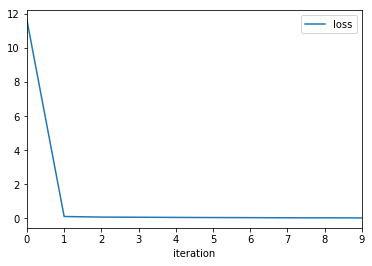

In [23]:
metrics_small.plot(x='iteration', y='loss')

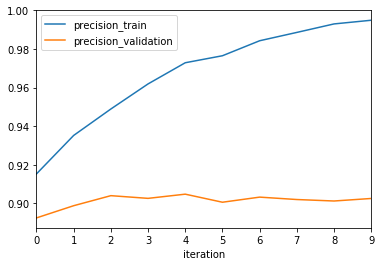

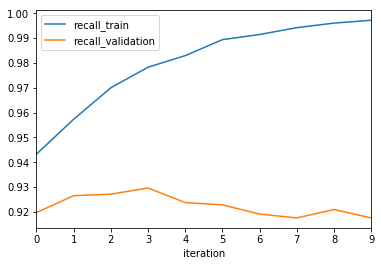

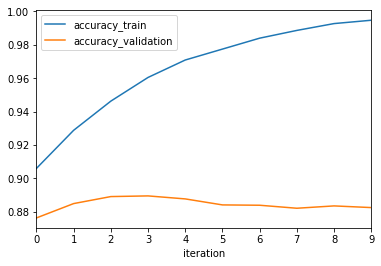

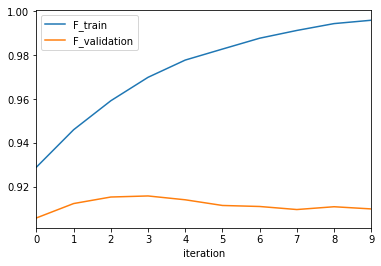

In [24]:
for metric in ["precision", "recall", "accuracy", "F"]:
    ax = metrics_small.plot(x="iteration", y=f"{metric}_train")
    metrics_small.plot(x="iteration", y=f"{metric}_validation", ax=ax)

In [25]:
def plot_cm(cm, percent=True, labels=('POSITIVE', 'NEGATIVE'), title="Confusion Matrix"):
    # from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
    if percent:
        matrix = cm / cm.sum()
    else:
        matrix = cm
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

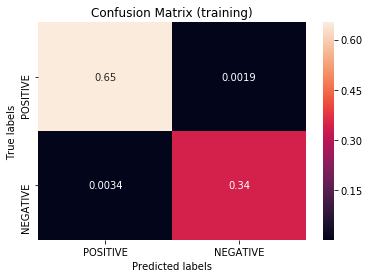

In [27]:
# iloc[-1] gets the last row (i.e., the most recent iteration)
plot_cm(metrics_small['cm_train'].iloc[-1], title="Confusion Matrix (training)")

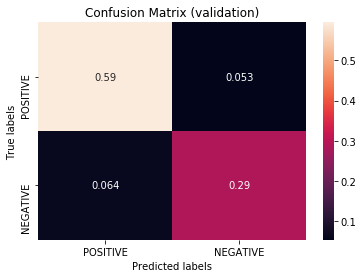

In [28]:
plot_cm(metrics_small['cm_validation'].iloc[-1], title="Confusion Matrix (validation)")

Did our validation set have a different percentage of positive examples than our test set?

In [29]:
_, train_cats = train_info
num_n = 0
for row in train_cats:
    for key, value in row.items():
        if key == 'NEGATIVE' and value is True:
            num_n += 1
num_p = len(train_cats) - num_n
print(f"{num_p} positive examples, {num_n} negative examples, {num_p/len(train_cats)*100:.2f}% positive")

13069 positive examples, 6931 negative examples, 65.34% positive


In [31]:
_, dev_cats = dev_info
dev_n = 0
dev_p = 0
for row in dev_cats:
    for key, value in row.items():
        if key == 'NEGATIVE' and value is True:
            dev_n += 1
dev_p = len(dev_cats) - dev_n
print(f"{dev_p} positive examples, {dev_n} negative examples, {dev_p/len(dev_cats)*100:.2f}% positive")

3241 positive examples, 1759 negative examples, 64.82% positive


### Bag of words

In [32]:
train_data, nlp, train_info, dev_info = prepare_training(train, n_texts=25000, train_split=0.8, cfg={"exclusive_classes": True, "architecture": "bow"})
metrics_small = do_training(train_data, nlp, train_info, dev_info, labels=('POSITIVE', 'NEGATIVE'), n_iter=10)

Loading data...
Using 25000 examples (20000 training, 5000 evaluation)
Training the model...
	precision	recall	F-score	accuracy
iteration: 0, loss: 11.10580
training scores, then validation scores
{'precision': 0.9150456822864499, 'recall': 0.95026398347165, 'F': 0.9323223602711124, 'accuracy': 0.9098499999991803, 'tp': 12419.00000001, 'tn': 5778.00000001, 'fp': 1153.00000001, 'fn': 650.00000001}
{'precision': 0.8785377358468247, 'recall': 0.9194692995963007, 'F': 0.8985376149531221, 'accuracy': 0.8653999999970768, 'tp': 2980.00000001, 'tn': 1347.00000001, 'fp': 412.00000001, 'fn': 261.00000001}
iteration: 1, loss: 0.11979
training scores, then validation scores
{'precision': 0.9315271300608016, 'recall': 0.9628892799748061, 'F': 0.9469486041079885, 'accuracy': 0.9294999999991409, 'tp': 12584.00000001, 'tn': 6006.00000001, 'fp': 925.00000001, 'fn': 485.00000001}
{'precision': 0.8874703087862977, 'recall': 0.9222462202997702, 'F': 0.9045241337545498, 'accuracy': 0.8737999999970096, 'tp'

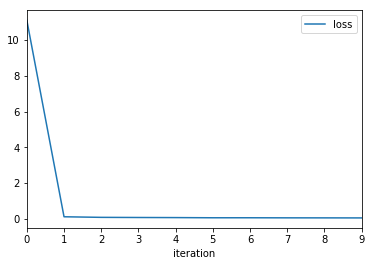

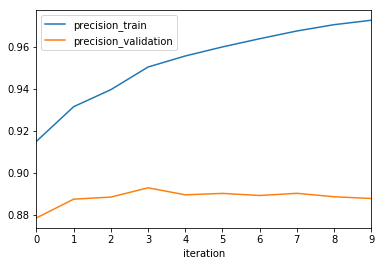

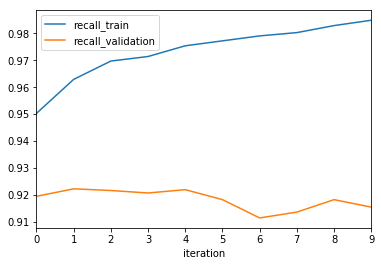

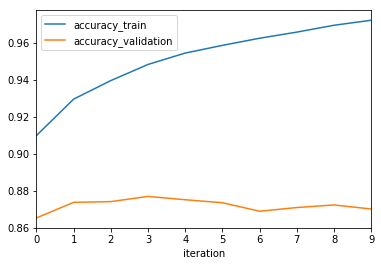

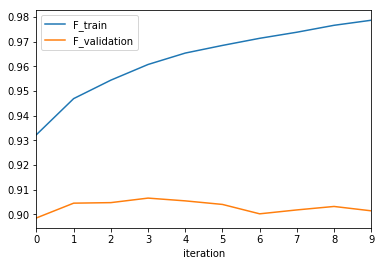

In [33]:
metrics_small.plot(x='iteration', y='loss')
for metric in ["precision", "recall", "accuracy", "F"]:
    ax = metrics_small.plot(x="iteration", y=f"{metric}_train")
    metrics_small.plot(x="iteration", y=f"{metric}_validation", ax=ax)

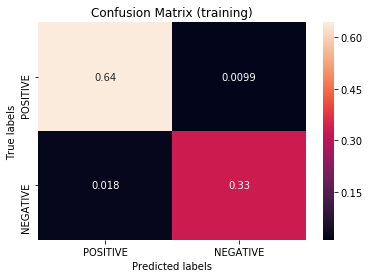

In [34]:
plot_cm(metrics_small['cm_train'].iloc[-1], title="Confusion Matrix (training)")

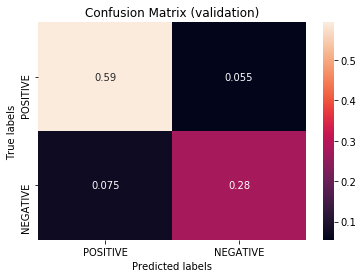

In [35]:
plot_cm(metrics_small['cm_validation'].iloc[-1], title="Confusion Matrix (validation)")

## Multiclass classification (star rating)

### Bag of words

In [36]:
train_star = reviews['star_tuples'].tolist()

In [52]:
star_labels = [str(star) for star in range(1,6)]
train_data, nlp, train_info, dev_info = prepare_training(train_star, n_texts=25000, train_split=0.8, cfg={"exclusive_classes": True, "architecture": "bow"},
                                                        labels=star_labels, cat_function=starcats_from_labels)
metrics_small = do_training(train_data, nlp, train_info, dev_info, labels=star_labels, n_iter=10)

Loading data...
Using 25000 examples (20000 training, 5000 evaluation)
Training the model...
	precision	recall	F-score	accuracy
iteration: 0, loss: 24.05654
training scores, then validation scores
              precision    recall  f1-score   support

           1       0.76      0.80      0.78      2462
           2       0.65      0.45      0.53      1864
           3       0.63      0.51      0.56      2605
           4       0.64      0.60      0.62      5225
           5       0.75      0.88      0.81      7844

    accuracy                           0.71     20000
   macro avg       0.69      0.65      0.66     20000
weighted avg       0.70      0.71      0.70     20000

              precision    recall  f1-score   support

           1       0.63      0.73      0.68       559
           2       0.42      0.22      0.29       513
           3       0.41      0.32      0.36       687
           4       0.47      0.46      0.46      1280
           5       0.69      0.81      0.75

iteration: 8, loss: 0.16756
training scores, then validation scores
              precision    recall  f1-score   support

           1       0.93      0.95      0.94      2462
           2       0.93      0.86      0.89      1864
           3       0.90      0.82      0.86      2605
           4       0.86      0.82      0.84      5225
           5       0.88      0.95      0.91      7844

    accuracy                           0.89     20000
   macro avg       0.90      0.88      0.89     20000
weighted avg       0.89      0.89      0.89     20000

              precision    recall  f1-score   support

           1       0.62      0.69      0.65       559
           2       0.41      0.27      0.32       513
           3       0.41      0.37      0.39       687
           4       0.48      0.48      0.48      1280
           5       0.72      0.78      0.74      1961

    accuracy                           0.58      5000
   macro avg       0.53      0.52      0.52      5000
weighted 

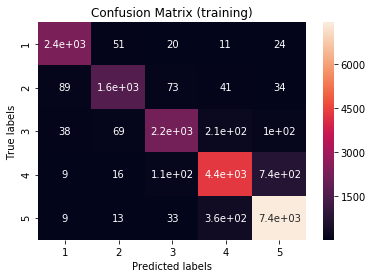

In [38]:
plot_cm(metrics_small['cm_train'].iloc[-1], title="Confusion Matrix (training)", labels=star_labels, percent=False)

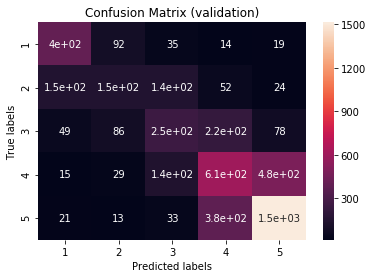

In [39]:
plot_cm(metrics_small['cm_validation'].iloc[-1], title="Confusion Matrix (validation)", labels=star_labels, percent=False)

Did our validation set have a different percentage of positive examples than our test set?

In [53]:
star_labels

['1', '2', '3', '4', '5']

In [62]:
_, train_cats = train_info
train_cat_counts = {label: 0 for label in star_labels}
for row in train_cats:
    for key, value in row.items():
        if value is True:
            train_cat_counts[key] += 1
print(train_cat_counts)

{'1': 2462, '2': 1864, '3': 2605, '4': 5225, '5': 7844}


In [57]:
_, dev_cats = dev_info
dev_cat_counts = {label: 0 for label in star_labels}
for row in dev_cats:
    for key, value in row.items():
        if value is True:
            dev_cat_counts[key] += 1
dev_cat_counts

{'1': 559, '2': 513, '3': 687, '4': 1280, '5': 1961}